####     From this notebook we get:
        "Figure 14: Fuel consumption and emissions with and without current influence for deep (6 m) and shallow (2.5 m) 
        water depth ".
####    General steps:
        -First we create and run the basic simulation of the ship sailing on the waterway.
        -Next we add current influence into the simulation.
        -Then we plot the figure based on the results of the fuel consumption and emissions from the simulation.

## Basic simulation - consumes energy-van Dosser actual draught & payload
We are going to make a simulation which forces a vessel to move over a certain 1D waterway network. It tries to give one an understanding of the most basic core functions of OpenTNSim and teach one the requirements to set-up a basic OpenTNSim model run. 

We add some properties to the graph (depth) and the vessel (VesselProperties, ConsumesEnergy) in order to calculate resistance, required power, 

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import logging
# turn on debug messages
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages
logging.basicConfig(level=logging.INFO)

### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).


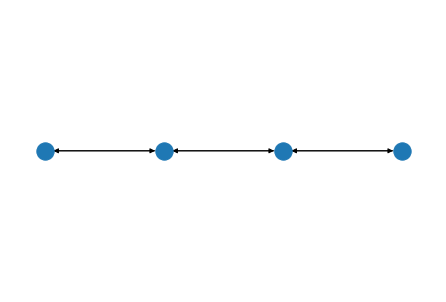

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1

for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 6})
    
middle_edges = [
    (node_2.name, node_3.name),
    (node_3.name, node_2.name)
]

for e in middle_edges:
    edge = FG.edges[e]
    edge['Info']['GeneralDepth'] = 2.5
    
# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 6
General depth for edge ('Node 2', 'Node 3') is 2.5
General depth for edge ('Node 2', 'Node 1') is 6
General depth for edge ('Node 3', 'Node 4') is 6
General depth for edge ('Node 3', 'Node 2') is 2.5
General depth for edge ('Node 4', 'Node 3') is 6


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption. 

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [5]:
# Create a dict with all important settings
data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v":None,  # m/s
               "type": None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_e": None, 
               "H_f": None, 
               "T":None, 
               "P_installed":1750.0,   
               "P_tot_given": None, # kW
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
               "current_year":None
              }               

vessel = TransportResource(**data_vessel)
print('parameters not used', vessel.metadata)


parameters not used {}


### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [6]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [7]:
def run_simulation(V_s, P_tot_given):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

In [8]:
input_data = {'V_s': [3.5],'P_tot_given': [None]}
input_data

{'V_s': [3.5], 'P_tot_given': [None]}

In [ ]:
# loop through the various input data
for index, value in enumerate(input_data['V_s']):
    
    # Run a basic simulation with V_s and P_tot_given combi
    vessel = run_simulation(input_data['V_s'][index], input_data['P_tot_given'][index])
    
    # create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()


In [ ]:
# create dataframe from energy calculation computation
df = pd.DataFrame.from_dict(energycalculation.energy_use)
      
# add current influence
# with current speed =0.5m/s
U_c=0.5 
# delta_t will be longer when upstream, shorter when downstream
delta_t_up=df['distance']/(df['distance']/df['delta_t']-U_c)
delta_t_down=df['distance']/(df['distance']/df['delta_t']+U_c)
# total emission&fuel consumption will be larger when upstream(because of longer delta_t), smaller when downstream(because of shorter delta_t)
df['total_fuel_consumption_kg']=df['total_fuel_consumption']/1000 #kg without current
df['total_fuel_consumption_up_kg']=df['total_fuel_consumption']/1000 *(delta_t_up/df['delta_t']) #kg
df['total_fuel_consumption_down_kg']=df['total_fuel_consumption']/1000 *(delta_t_down/df['delta_t']) #kg
df['total_fuel_consumption_round_no_current_kg']=df['total_fuel_consumption']/1000*2 #kg
df['total_fuel_consumption_round_current_kg']=df['total_fuel_consumption_up_kg']+df['total_fuel_consumption_down_kg'] #kg
df['total_emission_CO2_kg']=df['total_emission_CO2']/1000 #kg without current
df['total_emission_CO2_up_kg']=df['total_emission_CO2'] *(delta_t_up/df['delta_t'])/1000 #kg
df['total_emission_CO2_down_kg']=df['total_emission_CO2'] *(delta_t_down/df['delta_t'])/1000 #kg
df['total_emission_CO2_round_no_current_kg']=df['total_emission_CO2']*2/1000 #kg
df['total_emission_CO2_round_current_kg']=df['total_emission_CO2_up_kg']+df['total_emission_CO2_down_kg'] #kg
df['total_emission_PM10_kg']=df['total_emission_PM10']/1000 #kg without current
df['total_emission_PM10_up_kg']=df['total_emission_PM10'] *(delta_t_up/df['delta_t'])/1000 #kg
df['total_emission_PM10_down_kg']=df['total_emission_PM10'] *(delta_t_down/df['delta_t'])/1000 #kg
df['total_emission_PM10_round_no_current_kg']=df['total_emission_PM10']*2/1000 #kg
df['total_emission_PM10_round_current_kg']=df['total_emission_PM10_up_kg']+df['total_emission_PM10_down_kg'] #kg
df['total_emission_NOX_kg']=df['total_emission_NOX']/1000 #kg without current
df['total_emission_NOX_up_kg']=df['total_emission_NOX'] *(delta_t_up/df['delta_t'])/1000 #kg
df['total_emission_NOX_down_kg']=df['total_emission_NOX'] *(delta_t_down/df['delta_t'])/1000 #kg
df['total_emission_NOX_round_no_current_kg']=df['total_emission_NOX']*2/1000 #kg
df['total_emission_NOX_round_current_kg']=df['total_emission_NOX_up_kg']+df['total_emission_NOX_down_kg'] #kg
    

In [ ]:
fuel=df[['total_fuel_consumption_kg','total_fuel_consumption_up_kg','total_fuel_consumption_down_kg',
          'total_fuel_consumption_round_no_current_kg','total_fuel_consumption_round_current_kg']].T
fuel.index=['single trip \n no current \n either way', 'single trip \n upstream',
                    'single trip \n downstream', 'round trip \n no current', 'round trip \n current']
fuel.columns =['section 1','section 2','section 3']
fuel.head()

In [ ]:
fuel_colors=['#7f4e1e','#bf9005','#f1da7a']
fuel.plot(kind='bar', stacked=True,color=fuel_colors,rot=0, figsize=(8, 3))


In [ ]:
CO2=df[['total_emission_CO2_kg','total_emission_CO2_up_kg','total_emission_CO2_down_kg',
          'total_emission_CO2_round_no_current_kg','total_emission_CO2_round_current_kg']].T
CO2.index=['single trip \n no current \n either way', 'single trip \n upstream',
                    'single trip \n downstream', 'round trip \n no current', 'round trip \n current']
CO2.columns =['section 1','section 2','section 3']
CO2.head()


In [ ]:
CO2_colors=['red','orange','yellow']
CO2.plot(kind='bar', stacked=True,color=CO2_colors,rot=0, figsize=(8, 3))

In [ ]:
PM10=df[['total_emission_PM10_kg','total_emission_PM10_up_kg','total_emission_PM10_down_kg',
          'total_emission_PM10_round_no_current_kg','total_emission_PM10_round_current_kg']].T
PM10.index=['single trip \n no current \n either way', 'single trip \n upstream',
                    'single trip \n downstream', 'round trip \n no current', 'round trip \n current']
PM10.columns =['section 1','section 2','section 3']
PM10.head()

In [ ]:
PM10_colors=['darkgreen','mediumseagreen','paleturquoise']
PM10.plot(kind='bar', stacked=True,color=PM10_colors,rot=0, figsize=(8, 3))

In [ ]:
NOX=df[['total_emission_NOX_kg','total_emission_NOX_up_kg','total_emission_NOX_down_kg',
          'total_emission_NOX_round_no_current_kg','total_emission_NOX_round_current_kg']].T
NOX.index=['single trip \n no current \n either way', 'single trip \n upstream',
                    'single trip \n downstream', 'round trip \n no current', 'round trip \n current']
NOX.columns =['section 1','section 2','section 3']
NOX.head()

In [ ]:
NOX_colors=['purple','deeppink','pink']
NOX.plot(kind='bar', stacked=True,color=NOX_colors,rot=0, figsize=(8, 3))

## Figure 14

Fuel using and emissions of an M8 vessel with and without current influence. Assuming that the adjusted loaded (1393 ton payload) M8 vessel sails with actual draught 2.2 m between inland terminal and sea port with (or without) mild current 0.5 m/s (from inland terminal to sea port. The total distance of  the waterway is 300 km, divided into 3 sections: section 1 (from 0 km to 100 km), section 2 (from 100 km to 200 km), section 3 (from 200 km to 300 km); The water depth is 6 m in section 1 and section 3, 2.5 m in section 2. When there is no current, the vessel speed to the water(and ground) is 3.5 m/s; when there is the current, the vessel sails upstream (from sea port to inland terminal) with speed 3.5 m/s to the water, equaling to 3 m/s to the ground; the vessel sails downstream (from inland terminal to sea port) with speed 3.5 m/s to the water, equaling to 4 m/s to the ground. A round trip with current includes a single upstream trip and a single downstream trip. M8 ship characteristics: engine construction year = 1990, installed engine power = 1750 kW, length =110 m, beam = 11.4m, DWT = 3000 ton.


In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(8, 12),sharex=True)
fuel.plot(ax=axes[0],kind='bar', stacked=True,color=fuel_colors,rot=0)
plt.yticks(weight = 'bold', fontsize=12)
axes[0].set_ylim(0, 8000)
axes[0].set_ylabel('Total fuel use \n (kg)',fontsize=12,fontweight='bold',labelpad=12)
axes[0].annotate('(a)', xy=(4.27, 8000*7/8), fontsize=12,weight = 'bold')
axes[0].set_yticklabels(axes[0].get_yticks(), size=12,weight = 'bold')  
axes[0].legend(loc='upper left')
axes[0].set_title('M8 vessel: L$_s$ = 110 m, B$_s$ = 11.40 m, T$_s$ = 2.2 m, actual load = 1393 ton;\n  V$_s$= 3.5 m/s, U$_c$= 0.5 m/s, section 1 & 3: h$_0$ = 6 m, section 2: h$_0$ = 2.5 m')

CO2.plot(ax=axes[1],kind='bar', stacked=True,color=CO2_colors,rot=0)
axes[1].set_ylim(0, 20000)
axes[1].set_ylabel('Total CO2 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=3)
axes[1].set_yticklabels(axes[1].get_yticks(), size=12,weight = 'bold')  
axes[1].annotate('(b)', xy=(4.27, 20000*7/8), fontsize=12,weight = 'bold')
axes[1].legend(loc='upper left')

PM10.plot(ax=axes[2],kind='bar', stacked=True,color=PM10_colors,rot=0)
axes[2].set_ylim(0, 14)
axes[2].set_ylabel('Total PM10 emission \n (kg)',fontsize=12,fontweight='bold',labelpad=27)
axes[2].annotate('(c)', xy=(4.27, 14*7/8), fontsize=12,weight = 'bold')
axes[2].set_yticklabels(axes[2].get_yticks(), size=12,weight = 'bold')  
axes[2].legend(loc='upper left')

NOX.plot(ax=axes[3],kind='bar', stacked=True,color=NOX_colors,rot=0)
axes[3].set_ylim(0, 300)
axes[3].set_ylabel('Total NOx emission \n (kg)',fontsize=12,fontweight='bold',labelpad=20)
#axes[3].set_xticklabels(axes[3].get_xticks(), size=12,weight = 'bold')  
axes[3].set_yticklabels(axes[3].get_yticks(), size=12,weight = 'bold')  
axes[3].annotate('(d)', xy=(4.27, 300*7/8), fontsize=12,weight = 'bold')
axes[3].legend(loc='upper left')
# plt.yticks(weight = 'bold', fontsize=12)
plt.xticks( weight = 'bold', fontsize=12)

plt.savefig('Fig_14.pdf',bbox_inches = 'tight', dpi=600, format='pdf')  
plt.show()